In [ ]:
## Augusto Paulo Schmidt
## link: "https://colab.research.google.com/drive/1Od2Zzq3RJBeKmJ4O0Z-Hj5Dr3gLs_ujQ?usp=sharing"
!pip install yfinance requests pandas numpy scipy matplotlib python-bcb # Só para garantir as bibliotecas

# Parte I

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from bcb import sgs
import matplotlib.pyplot as plt
import requests


def obter_dados_historicos(simbolo, data_inicio, data_fim):
    url = f"https://www.okanebox.com.br/api/acoes/hist/{simbolo}/{data_inicio}/{data_fim}/"
    resposta = requests.get(url)

    if resposta.status_code == 200:
        dados_json = resposta.json()
        df = pd.DataFrame(dados_json)

        # Converter a data para índice e manter apenas o preço ajustado (PREULT)
        df['DATPRG'] = pd.to_datetime(df['DATPRG'], format='ISO8601')
        df.set_index('DATPRG', inplace=True)
        df = df[['PREULT']].rename(columns={'PREULT': simbolo})

        return df
    else:
        print(f"Erro ao obter dados para {simbolo}. Código: {resposta.status_code}")
        return None

# Lista de ações da B3
acoes = [
    "BBDC4", "SBSP3", "ELET3", "B3SA3", "SUZB3",
    "EQTL3", "RENT3", "RDOR3", "RADL3", "BRFS3",
    "RAIL3", "VBBR3", "ENEV3", "CPLE6", "CCRO3",
    "EGIE3", "CSNA3", "HYPE3", "CPFE3", "BEEF3"
]

# Período de análise
data_inicio = "20231231"
data_fim = "20241231"

# Criar um dicionário com os DataFrames individuais de cada ação
dados_acoes = {}

for acao in acoes:
    df = obter_dados_historicos(acao, data_inicio, data_fim)
    if df is not None:
        dados_acoes[acao] = df
        print(f"Dados de {acao} armazenados com sucesso.")
    else:
        print(f"Não foi possível obter os dados de {acao}.")

# Combinar todas as ações em um único DataFrame com apenas os preços ajustados
df_precios = pd.concat(dados_acoes.values(), axis=1)

# Exibir as primeiras linhas para verificar
print("\nDados combinados:\n")
print(df_precios.head())

# Calcular os retornos diários
returns = df_precios.pct_change().dropna()

# Exibir os retornos diários calculados para ver se deu certo
print("\nRetornos diários:\n")
print(returns.head())



Dados de BBDC4 armazenados com sucesso.
Dados de SBSP3 armazenados com sucesso.
Dados de ELET3 armazenados com sucesso.
Dados de B3SA3 armazenados com sucesso.
Dados de SUZB3 armazenados com sucesso.
Dados de EQTL3 armazenados com sucesso.
Dados de RENT3 armazenados com sucesso.
Dados de RDOR3 armazenados com sucesso.
Dados de RADL3 armazenados com sucesso.
Dados de BRFS3 armazenados com sucesso.
Dados de RAIL3 armazenados com sucesso.
Dados de VBBR3 armazenados com sucesso.
Dados de ENEV3 armazenados com sucesso.
Dados de CPLE6 armazenados com sucesso.
Dados de CCRO3 armazenados com sucesso.
Dados de EGIE3 armazenados com sucesso.
Dados de CSNA3 armazenados com sucesso.
Dados de HYPE3 armazenados com sucesso.
Dados de CPFE3 armazenados com sucesso.
Dados de BEEF3 armazenados com sucesso.

Dados combinados:

            BBDC4  SBSP3  ELET3  B3SA3  SUZB3  EQTL3  RENT3  RDOR3  RADL3  \
DATPRG                                                                      
2024-02-14  13.37  78.99  

In [ ]:
# Calcular volatilidade anualizada de cada ação
volatilidades = returns.std() * np.sqrt(252) # 252 dias úteis
print("\nVolatilidade anualizada de cada ação:")
print(volatilidades) # Aqui vai imprimir apenas um tipo no fim, além das volatilidades. float64 é o tipo.

# Calcular volatilidade de um portfólio igualmente distribuído (5% cada ação)
pesos_iguais = np.ones(len(acoes)) / len(acoes)
cov_matrix = returns.cov() * 252  # Matriz de covariância anualizada
vol_portfolio_igual = np.sqrt(np.dot(pesos_iguais.T, np.dot(cov_matrix, pesos_iguais)))

print("\nVolatilidade do portfólio igualmente distribuído:", vol_portfolio_igual)

# Otimizar o portfólio para mínima volatilidade
def volatilidade_portfolio(pesos, cov_matrix):
    return np.sqrt(np.dot(pesos.T, np.dot(cov_matrix, pesos)))

def restricao_soma(pesos):
    return np.sum(pesos) - 1  # Restrição: soma dos pesos = 100%

# Restrições
restricoes = ({'type': 'eq', 'fun': restricao_soma})
limites = [(0, 0.1)] * len(acoes)  # Cada ação pode ter entre 0% e 10%

# Otimização
resultado = minimize(volatilidade_portfolio, pesos_iguais, args=(cov_matrix,),
                     method='SLSQP', bounds=limites, constraints=restricoes) # A função minimize já combina e minimiza o primeiro fator, neste caso, volatilidade)

pesos_min_vol = resultado.x
vol_min = resultado.fun

print("\nAlocação para mínima volatilidade:")
print(dict(zip(acoes, pesos_min_vol)))
print("\nVolatilidade mínima:", vol_min)

# Pegando os valores da Selic como taxa livre de risco

codigo_serie = 432 # Código da série temporal da taxa SELIC no SGS é 432


data_inicio = '2023-12-31'
data_fim = '2024-12-31'

selic = sgs.get(codigo_serie, start=data_inicio, end=data_fim)
selic_media_anualizada = selic.mean().values[0] / 100 # Média


# Otimizar para o maior Sharpe Ratio
retornos_medios = returns.mean() * 252  # Retorno médio anualizado

def sharpe_negativo(pesos, retornos, cov_matrix, taxa_livre_risco):
    retorno_port = np.dot(pesos, retornos)
    vol_port = np.sqrt(np.dot(pesos.T, np.dot(cov_matrix, pesos)))
    return -(retorno_port - taxa_livre_risco) / vol_port  # Negativo para quando minimizado, atingir o máximo

# Otimização
resultado_sharpe = minimize(sharpe_negativo, pesos_iguais,
                            args=(retornos_medios, cov_matrix, selic_media_anualizada),
                            method='SLSQP', bounds=limites, constraints=restricoes)

pesos_max_sharpe = resultado_sharpe.x
sharpe_max = -resultado_sharpe.fun  # Como minimizamos o negativo, pegamos o valor positivo
vol_sharpe = np.sqrt(np.dot(pesos_max_sharpe.T, np.dot(cov_matrix, pesos_max_sharpe)))

print(f"Melhor Índice de Sharpe: {sharpe_max:.4f}")
print(f"Volatilidade da alocação com maior Sharpe: {vol_sharpe:.4%}")

print("\nAlocação para máximo Sharpe:")
print(dict(zip(acoes, pesos_max_sharpe)))
print("\nSharpe máximo:", sharpe_max)
print("\nVolatilidade da alocação com maior Sharpe:", vol_sharpe)


Volatilidade anualizada de cada ação:
BBDC4    0.221112
SBSP3    0.242446
ELET3    0.230740
B3SA3    0.288723
SUZB3    0.280990
EQTL3    0.236615
RENT3    0.416507
RDOR3    0.298802
RADL3    0.272008
BRFS3    0.395743
RAIL3    0.248875
VBBR3    0.272152
ENEV3    0.269284
CPLE6    0.217795
CCRO3    0.247932
EGIE3    0.184661
CSNA3    0.415732
HYPE3    0.340295
CPFE3    0.189700
BEEF3    0.403403
dtype: float64

Volatilidade do portfólio igualmente distribuído: 0.16414968586191522

Alocação para mínima volatilidade:
{'BBDC4': 0.1, 'SBSP3': 0.09999999999999998, 'ELET3': 0.055771296809423006, 'B3SA3': 0.0, 'SUZB3': 0.1, 'EQTL3': 7.059297893257243e-17, 'RENT3': 4.772159018398165e-17, 'RDOR3': 0.028413267627968645, 'RADL3': 0.0711265272596727, 'BRFS3': 0.05091457236149832, 'RAIL3': 0.038724574369872845, 'VBBR3': 0.03420895078291064, 'ENEV3': 0.062294580667204696, 'CPLE6': 0.09999999999999998, 'CCRO3': 3.23958001120137e-17, 'EGIE3': 0.1, 'CSNA3': 0.008797964353952671, 'HYPE3': 0.049748265767

À princípio, parece errado que o índice sharpe dê negativo, entretanto, isso só significa que não há composição de carteira, dado os limites, que tenha uma rentabilidade maior que a taxa livre de risco. Entretanto, não há como julgar entre índices mais ou menos negativos, e o índice de Sharpe perde sua potencial utilidade. Para ilustrar o ponto, irei demonstrar que apenas dois dos vinte ativos possuem rentabilidade no período acima da taxa livre de risco.

In [ ]:
for acao, retorno in retornos_medios.items():  # Iteração sobre cada retorno das 20 ações
  if retorno > selic_media_anualizada:
    print(f"{acao}: {retorno - selic_media_anualizada:.4f}") # Só imprime se for maior que a Selic

SBSP3: 0.0904
SUZB3: 0.1241
BRFS3: 0.4278


Como alternativa, como observamos que apenas três ações tem um desempenho superior à Selic, podemos mudar os parâmetros de máxima composição de 10% para 33% e observar se conseguimos gerar um Índice de Sharpe positivo.

In [ ]:
# Caso alterado (fora do escopo original)
restricoes_alt = ({'type': 'eq', 'fun': restricao_soma})
limites_alt = [(0, 0.33)] * len(acoes)  # Cada ação pode ter entre 0% e 33%

resultado_sharpe_alt = minimize(sharpe_negativo, pesos_iguais,
                            args=(retornos_medios, cov_matrix, selic_media_anualizada),
                            method='SLSQP', bounds=limites_alt, constraints=restricoes_alt)

pesos_max_sharpe_alt = resultado_sharpe_alt.x
sharpe_max_alt = -resultado_sharpe_alt.fun

vol_sharpe_alt = np.sqrt(np.dot(pesos_max_sharpe_alt.T, np.dot(cov_matrix, pesos_max_sharpe_alt)))

print(f"Melhor Índice de Sharpe: {sharpe_max_alt:.4f}")
print(f"Volatilidade da alocação com maior Sharpe: {vol_sharpe_alt:.4%}")

print("\nAlocação para máximo Sharpe:")
print(dict(zip(acoes, pesos_max_sharpe_alt)))
print("\nSharpe máximo:", sharpe_max_alt)
print("\nVolatilidade da alocação com maior Sharpe:", vol_sharpe_alt)


Melhor Índice de Sharpe: 1.0841
Volatilidade da alocação com maior Sharpe: 19.5494%

Alocação para máximo Sharpe:
{'BBDC4': 0.0, 'SBSP3': 0.32999999999999935, 'ELET3': 0.0, 'B3SA3': 0.0, 'SUZB3': 0.3299999999999889, 'EQTL3': 1.6445071348907302e-16, 'RENT3': 1.5038200892643762e-15, 'RDOR3': 0.010000000000010417, 'RADL3': 0.0, 'BRFS3': 0.32999999999999635, 'RAIL3': 2.5527564393323775e-15, 'VBBR3': 9.416065833481653e-16, 'ENEV3': 1.3608955267697855e-15, 'CPLE6': 0.0, 'CCRO3': 0.0, 'EGIE3': 0.0, 'CSNA3': 1.747806810544542e-15, 'HYPE3': 5.201971553732414e-16, 'CPFE3': 0.0, 'BEEF3': 4.740980421011595e-15}

Sharpe máximo: 1.0841253575491423

Volatilidade da alocação com maior Sharpe: 0.1954943688639482


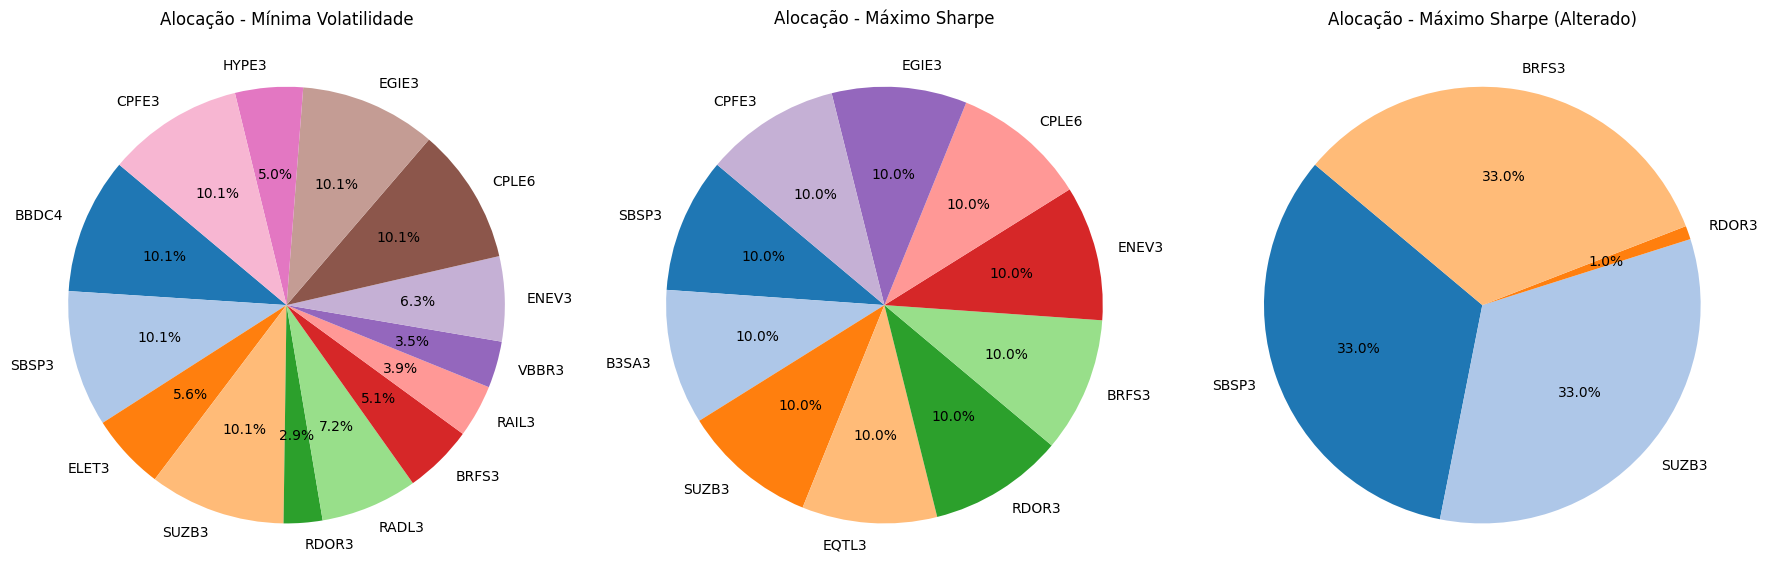

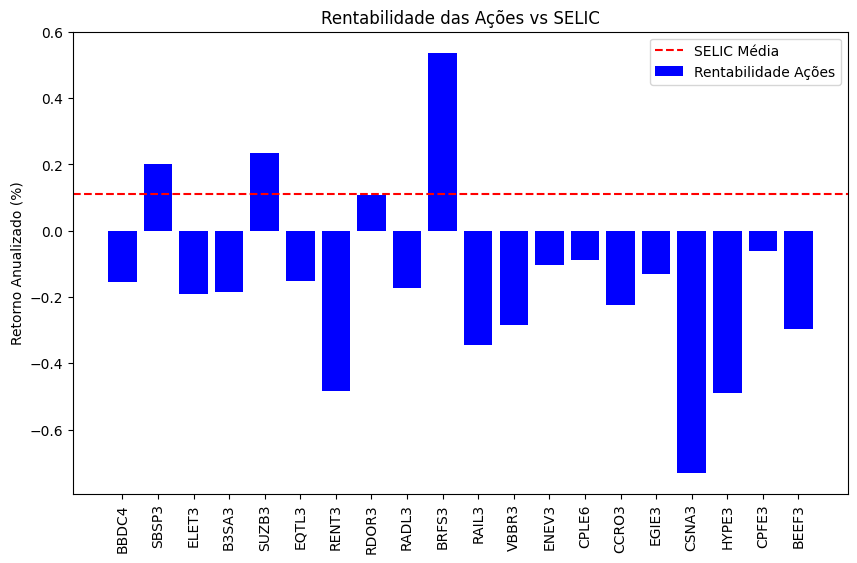

In [ ]:
# Plot de gráficos para ficar mais fácil de visualizar
def plot_pie_charts_side_by_side(pesos_list, labels, titles):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 linha, 3 colunas

    for i, (pesos, title, ax) in enumerate(zip(pesos_list, titles, axes)):
        # Filtrar ativos com alocação >= 1%
        pesos_filtrados = [peso for peso in pesos if peso >= 0.01]
        labels_filtrados = [labels[j] for j in range(len(pesos)) if pesos[j] >= 0.01]

        if len(pesos_filtrados) == 0:
            ax.axis('off')  # Se nenhum ativo for incluído, desativa o gráfico
            ax.set_title(f"{title} (Sem alocações >1%)")
            continue

        colors = plt.cm.tab20.colors  # Paleta de cores
        ax.pie(pesos_filtrados, labels=labels_filtrados, autopct='%1.1f%%', colors=colors, startangle=140)
        ax.set_title(title)

    plt.tight_layout()
    plt.show()

# Função para plotar rentabilidade das ações vs SELIC
def plot_rentabilidade(returns, selic):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Criar índice de ações e adicionar linha da SELIC
    indices = np.arange(len(returns))
    ax.bar(indices, returns, color='blue', label='Rentabilidade Ações')
    ax.axhline(y=selic, color='red', linestyle='--', label='SELIC Média')

    ax.set_xticks(indices)
    ax.set_xticklabels(acoes, rotation=90)
    ax.set_ylabel('Retorno Anualizado (%)')
    ax.set_title('Rentabilidade das Ações vs SELIC')
    ax.legend()

    plt.show()

# Gerar gráficos de pizza lado a lado
plot_pie_charts_side_by_side(
    [pesos_min_vol, pesos_max_sharpe, pesos_max_sharpe_alt],
    acoes,
    ['Alocação - Mínima Volatilidade', 'Alocação - Máximo Sharpe', 'Alocação - Máximo Sharpe (Alterado)']
)

# Gerar gráfico de rentabilidade das ações vs SELIC
plot_rentabilidade(retornos_medios, selic_media_anualizada)



In [ ]:


#acoes = ['BBDC4.SA', 'SBSP3.SA', 'ELET3.SA', 'B3SA3.SA', 'SUZB3.SA',
#           'EQTL3.SA', 'RENT3.SA', 'RDOR3.SA', 'RADL3.SA', 'BRFS3.SA',
#           'RAIL3.SA', 'VBBR3.SA', 'ENEV3.SA', 'CPLE6.SA', 'CCRO3.SA',
#           'EGIE3.SA', 'CSNA3.SA', 'HYPE3.SA', 'CPFE3.SA', 'BEEF3.SA']

# start_date = '2023-12-31'
# end_date = '2024-12-31'

# data = yf.download(acoes, start=start_date, end=end_date)['Adj Close']  # Armazena os dados históricos no período requisitado # Adj Close é o valor de fechamento ajustado

#### Por algum motivo, a yfinance não está reconhecendo a BBDC4.SA listada

# Parte II

In [33]:
import numpy as np

def fluxo_ntnb(valor_nominal, taxa_real, prazo, inflacao):
    """
    Calcula o fluxo de pagamentos da NTN-B, o preço unitário (PU) e a Duration de Macaulay.

    Parâmetros:
    - valor_nominal: Valor nominal do título
    - taxa_real: Taxa de juros real
    - prazo: Tempo até o vencimento em anos
    - inflacao: Inflação projetada ao ano

    Retorna:
    - PU (Preço Unitário)
    - Duration de Macaulay
    - Fluxo de pagamentos semestrais
    """

    n = prazo * 2  # Número de períodos semestrais
    taxa_real_sem = (1 + taxa_real) ** (1/2) - 1
    taxa_infla_sem = (1 + inflacao) ** (1/2) - 1
    taxa_nominal_sem = (1 + taxa_real_sem) * (1 + taxa_infla_sem) - 1

    # Inicialização das variáveis
    fluxos = []
    valores_presentes = []
    duration_numerador = 0

    # Cálculo dos fluxos de caixa
    for t in range(1, n + 1):
        principal_corrigido = valor_nominal * ((1 + taxa_infla_sem) ** t)  # Correção do principal
        juros_semestrais = principal_corrigido * taxa_real_sem # Juros em cima do montante corrigido

        if t == n:
            fluxo = juros_semestrais + principal_corrigido  # Último pagamento inclui o principal
        else:
            fluxo = juros_semestrais

        # Particularmente aqui, tive bastante dúvida acerca de como utilizar taxa pactuada, taxa real, taxa nominal...
        fator_desconto = (1 + taxa_infla_sem) ** t # Caso utilizasse a nominal, PU sempre seria 1000; Portanto, considerei VP com taxa de desconto = inflação
        vp = fluxo / fator_desconto
        fluxos.append((t, fluxo, vp))  # Armazena o período, fluxo e valor presente
        valores_presentes.append(vp)
        duration_numerador += t * vp  # Parte superior da fórmula da Duration

    # Cálculo do PU (soma dos valores presentes)
    PU = sum(valores_presentes)

    # Cálculo da Duration de Macaulay
    duration = duration_numerador / PU

    return PU, duration, fluxos

# Colhendo os dados de input; Alguns dados como valor nominal e inflação são adições ao modelo, para torná-lo mais flexível
valor_nominal = float(input("Digite o valor nominal do título: "))
prazo = int(input("Digite o prazo de vencimento (anos): "))
inflacao = float(input("Digite a inflação projetada (em decimal, ex: 0.04 para 4% a.a.): "))
taxa_real = float(input("Digite a taxa real de juros do contrato (em decimal, ex: 0.06 para 6% a.a.): "))

PU, duration, fluxos = fluxo_ntnb(valor_nominal, taxa_real, prazo, inflacao)

# Imprimindo os Outputs
print(f"\nPreço Unitário (PU): {PU:.2f}")
print(f"Duration de Macaulay: {duration:.2f} semestres")

print("\nFluxo de Pagamentos:")
for t, fluxo, vp in fluxos:
    print(f"Período {t}: Fluxo = {fluxo:.2f}, Valor Presente = {vp:.2f}")



Digite o valor nominal do título: 1000
Digite o prazo de vencimento (anos): 4
Digite a inflação projetada (em decimal, ex: 0.04 para 4% a.a.): 0.01
Digite a taxa real de juros do contrato (em decimal, ex: 0.06 para 6% a.a.): 0.1

Preço Unitário (PU): 1390.47
Duration de Macaulay: 7.02 semestres

Fluxo de Pagamentos:
Período 1: Fluxo = 49.05, Valor Presente = 48.81
Período 2: Fluxo = 49.30, Valor Presente = 48.81
Período 3: Fluxo = 49.54, Valor Presente = 48.81
Período 4: Fluxo = 49.79, Valor Presente = 48.81
Período 5: Fluxo = 50.04, Valor Presente = 48.81
Período 6: Fluxo = 50.29, Valor Presente = 48.81
Período 7: Fluxo = 50.54, Valor Presente = 48.81
Período 8: Fluxo = 1091.39, Valor Presente = 1048.81


# Parte III